In [46]:
import torch

# Losses in general
We have been using crossentropy loss. But what is that?

First, let's go back to what we want to do with a loss function: we want to give the model feedback on how good or bad it is working. With that information, it is able to adjust it's weights with the gradient.

So, it is really important! Using the wrong carrot/stick will cause your model to behave in completely different ways...

The most basic example is: we have a real value $y$, and a prediction $\hat{y}$

In [47]:
y = torch.tensor([3.0, 2.0, 5.0])
yhat = torch.tensor([2.5, 3.4, 4.0])

Text(0, 0.5, 'Values')

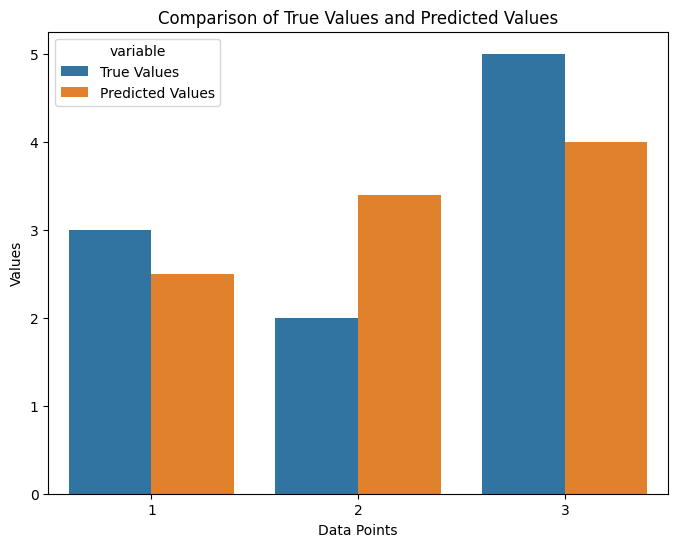

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

y_np = y.numpy()
yhat_np = yhat.numpy()

# Create a Pandas DataFrame containing the data
data = pd.DataFrame({'True Values': y_np, 'Predicted Values': yhat_np, 'Data Points': range(1, len(y_np) + 1)})

# Melt the DataFrame to have a 'variable' and 'value' columns
data_melted = data.melt(id_vars='Data Points', var_name='variable', value_name='value')

# Plot the data using Seaborn's pointplot
plt.figure(figsize=(8, 6))
sns.barplot(data=data_melted, x='Data Points', y='value', hue='variable')
plt.title('Comparison of True Values and Predicted Values')
plt.xlabel('Data Points')
plt.ylabel('Values')

## Regression
As you might be able to infer, this is a regression problem. We will cover the classification later on, because regression is a bit simpler. You can see, the predictions are off by a bit.

In [49]:
y - yhat

tensor([ 0.5000, -1.4000,  1.0000])

The most naive way to calculate the loss, is to look at the difference. Problem with this, is that if you take the mean, you run into problems

In [50]:
(y-yhat).mean()

tensor(0.0333)

The loss is very low, almost zero! A solution to this is to look at the absolute values, so that negative and positive values don't cancel out

In [51]:
(y-yhat).abs().mean()

tensor(0.9667)

This is what is called: Mean Average Error. However, this does typically not work that well as a loss function. The default for regression is a variation on this, the Mean Squared Error:

$$MSE = \frac{1}{n}\sum_{i=1}^n (Y_i - \hat{Y}_i)^2$$

This is the mean $\frac{1}{n}\sum_{i=1}^n$ of the squared error $(Y_i - \hat{Y}_i)^2$ 

In [52]:
((y-yhat)**2).mean()

tensor(1.0700)

But torch has already implemented that for us in an optimized way:

In [53]:
loss = torch.nn.MSELoss()
loss(yhat, y)

tensor(1.0700)

## Classification

For classification, we have to pull a bit more tricks, because models typically not give discrete output, but real valued output (floating point numbers).

Let's say you have five classes.
One way you could do this, is to predict the probability of every class.
The trick that is commonly used, is to have five output nodes. Every nodes gives a number, and you tell the model that the number should be high in the correct class.

In [54]:
torch.manual_seed(42)
n_observations = 3
n_classes = 5
input = torch.randn(n_observations, n_classes, requires_grad=True)
model = torch.nn.LogSoftmax(dim=1)
yhat = model(input)
print(f"the shape of the output is {yhat.shape}")
yhat

the shape of the output is torch.Size([3, 5])


tensor([[-1.3472, -1.5551, -1.4494, -1.4535, -2.8067],
        [-2.7779, -0.3834, -3.2296, -2.1299, -2.3242],
        [-1.4860, -1.2116, -0.9107, -3.7108, -3.0099]],
       grad_fn=<LogSoftmaxBackward0>)

We have three predictions, every prediction has 5 values. We applied a LogSoftmax layer to the output, which gives us the log of a softmax. A softmax function scales all the values, such that the sum is 1 (which is what you need for probabilities: it would be nonsense if you have a chance above 100% of something happening, right?)

You can verify for yourself that this sums to 1 for every observation, by taking the exponent:

<font color='green'>

By taking `sum` we can confirm that after `exp` the sum is equal to 1 for 3 observations.
</font>

In [55]:
torch.exp(yhat).sum(axis=1)

tensor([1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)

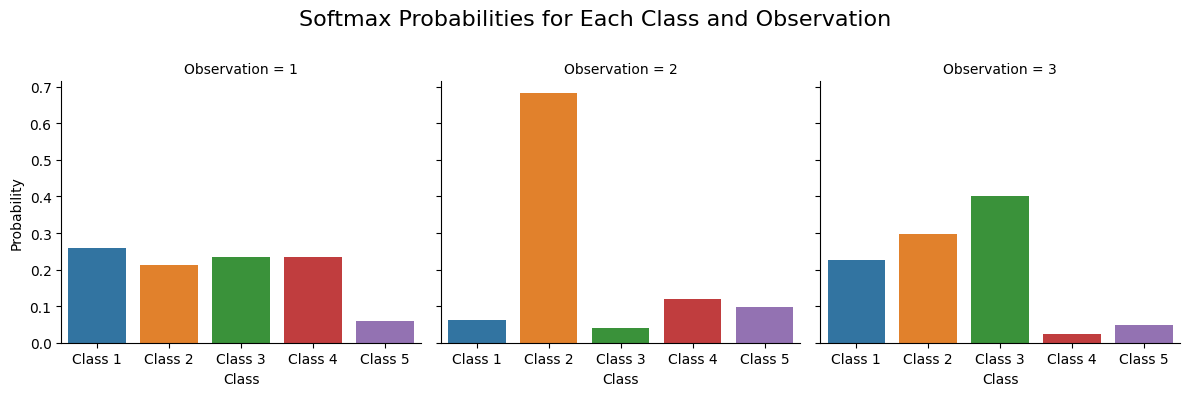

In [56]:
import warnings
# Suppress Seaborn warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

probabilities = torch.exp(yhat).detach().numpy()

# Create a Pandas DataFrame containing the data
data = pd.DataFrame(probabilities, columns=[f'Class {i}' for i in range(1, probabilities.shape[1] + 1)])
data['Observation'] = range(1, probabilities.shape[0] + 1)

# Melt the DataFrame to have a 'variable' and 'value' columns
data_melted = data.melt(id_vars='Observation', var_name='Class', value_name='Probability')

g = sns.FacetGrid(data_melted, col='Observation', col_wrap=3, height=4, aspect=1)

# Create the bar plots
g.map(sns.barplot, 'Class', 'Probability', order=[f'Class {i}' for i in range(1, probabilities.shape[1] + 1)], palette='tab10')

# Add titles and labels
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Softmax Probabilities for Each Class and Observation', fontsize=16)
g.set_axis_labels('Class', 'Probability')


Let's say the real classes are these:

In [57]:
y = torch.tensor([0, 1, 4])

A basic loss function is the negative log likelihood. The function is:

$$NLL = - log(\hat{y}[c])$$

Or, in plain language: take the probabilities $\hat{y}$, and pick the probability of the correct class $c$ from the list of probabilities with $\hat{y}[c]$. Now take the log of that.

The log has the effect that predicting closer to 0 if it should have been 1 is punished extra.

In our case, for the first observation, this means that we get $-log(0.26)$ (because the probability for the 0th class is 0.26). Because we used the LogSoftmaxed, we don't need to take the log and can just take $-(-1.3472)$ as the loss for our first case. For the second case, we have 0.6816 at the 1th index, of which the log is -0.3834. You can see, that the higher the probability, the closer to zero the loss value will be. We take the - value, because we want to minimize the loss.


In [58]:
loss = torch.nn.NLLLoss()
loss(yhat, y)

tensor(1.5802, grad_fn=<NllLossBackward0>)

You can check that this is equivalent if we do that manually:

In [59]:
loss = torch.zeros(3)
for observation, c in enumerate(y):
    loss[observation] = -yhat[observation, c]
loss.mean()

tensor(1.5802, grad_fn=<MeanBackward0>)

Now, CrossEntropyLoss does the same, but it adds the LogSoftmax to the loss. This means you don't need to add a LogSoftmax layer to your model.

In [60]:
loss = torch.nn.CrossEntropyLoss()
loss(input, y)

tensor(1.5802, grad_fn=<NllLossBackward0>)

# Multilabel

Now, what about the cases where your model can predict more than one class at once?

Let's say you have a model that looks at lung photos to determine a disease. You can predict three cases: lungcancer, pneumonia (longontsteking), pneumothorax (klaplong).

Now, let's imagine you have an unlucky patient with more than one condition. How would you want the model to predict this?

We will encode this with a multi hot encoding.
The prediction should be high, if there is a 1 in the target $y$, and low if there is a 0

In [61]:
y = torch.tensor([0., 1., 1.])

torch.manual_seed(7)
input = torch.randn(3, requires_grad=True) * 2
input

tensor([-0.2936,  1.5723,  1.8936], grad_fn=<MulBackward0>)

Here, both the chance at pneumonia and a pneumothorax are high values. But, a softmax wil ruin this:

In [62]:
input.softmax(dim=0)

tensor([0.0611, 0.3947, 0.5443], grad_fn=<SoftmaxBackward0>)

This sums to 1, but that is not what you want!
What you need is a sigmoid: this will scale everything between 0 and 1, but without making everything sum to 1:

In [63]:
m = torch.nn.Sigmoid()
yhat = m(input)
yhat

tensor([0.4271, 0.8281, 0.8692], grad_fn=<SigmoidBackward0>)


The loss function that goes with this is Binary Cross Entropy. A simplified version looks like this

$$ BCE = \frac{1}{n}\sum_{i=1}^n y_i \cdot log(\hat{y}_i) + (1-y_i) \cdot log(1-\hat{y}_i) $$

Or, in plain language: 
- assume that $y$ is a binary label (0 or 1)
- predict the probability $\hat{y}$
- if the label is 1, take the log of the probability: $y_i \cdot log(\hat{y}_i$)
- if the label is 0, take the log of $1-\hat{y}$
- take the mean $\frac{1}{n}\sum_{i=1}^n$ of that



In [64]:
loss = torch.nn.BCELoss()
loss(yhat, y)

tensor(0.2953, grad_fn=<BinaryCrossEntropyBackward0>)

Or, explicit:

In [65]:
loss = torch.zeros(3)
for i in range(len(y)):
    loss[i] = -(y[i] * torch.log(yhat[i]) + (1-y[i]) * torch.log(1-yhat[i]))
loss.mean()

tensor(0.2953, grad_fn=<MeanBackward0>)

In the case you dont have predictions with values between 0 and 1, you can use the WithLogits variation. You can then skip the sigmoid layer.

In [66]:
loss = torch.nn.BCEWithLogitsLoss()
loss(input, y)

tensor(0.2953, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

# Wrapup

Losses are very important: they tell your model what is "right" and "wrong" and determines what the model will learn!

- For regression models, typically use a MSE
- For classification, use CrossEntropyLoss (note: this might be implemented different in other libraries like Tensorflow!)
- For multiclass, use BinaryCrossEntropy

There are other, more complex losses for more complex usecases but these three will cover 80% of your needs.